In [16]:
import numpy as np
import nibabel as nb
import pandas as pd
from nilearn import image, masking, plotting
import glob
import re
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from scipy import stats
%matplotlib inline
plt.style.use('ggplot')

In [2]:
subject_list = range(101,115)+[116]+range(118,130)

### Load Data

In [3]:
def get_gm_data(image_stack):
    data_array = []
    for i in image_stack:
        i_data = i.get_data().ravel()
        i_data = i_data[i_data.nonzero()]
        data_array.append(i_data)
    return data_array

Get the paths to the lag maps.

In [4]:
aifo_rest1_minimal_paths = sorted(glob.glob('/home/despo/dlurie/Projects/megarest_lag/analysis/sub*/Aifo/sub*_Aifo_rest_1_minimal_lag10.nii.gz'))
aifo_rest2_minimal_paths = sorted(glob.glob('/home/despo/dlurie/Projects/megarest_lag/analysis/sub*/Aifo/sub*_Aifo_rest_2_minimal_lag10.nii.gz'))
aifo_rest3_minimal_paths = sorted(glob.glob('/home/despo/dlurie/Projects/megarest_lag/analysis/sub*/Aifo/sub*_Aifo_rest_3_minimal_lag10.nii.gz'))

aifo_rest1_gm_mask_paths = sorted(glob.glob('/home/despo/dlurie/Projects/megarest_lag/analysis/sub*/Aifo/sub*_Aifo_rest_1_minimal_gm_30p_mask.nii.gz'))
aifo_rest2_gm_mask_paths = sorted(glob.glob('/home/despo/dlurie/Projects/megarest_lag/analysis/sub*/Aifo/sub*_Aifo_rest_2_minimal_gm_30p_mask.nii.gz'))
aifo_rest3_gm_mask_paths = sorted(glob.glob('/home/despo/dlurie/Projects/megarest_lag/analysis/sub*/Aifo/sub*_Aifo_rest_3_minimal_gm_30p_mask.nii.gz'))

In [5]:
dlpfc_rest1_minimal_paths = sorted(glob.glob('/home/despo/dlurie/Projects/megarest_lag/analysis/sub*/Dlpfc/sub*_Dlpfc_rest_1_minimal_lag10.nii.gz'))
dlpfc_rest2_minimal_paths = sorted(glob.glob('/home/despo/dlurie/Projects/megarest_lag/analysis/sub*/Dlpfc/sub*_Dlpfc_rest_2_minimal_lag10.nii.gz'))
dlpfc_rest3_minimal_paths = sorted(glob.glob('/home/despo/dlurie/Projects/megarest_lag/analysis/sub*/Dlpfc/sub*_Dlpfc_rest_3_minimal_lag10.nii.gz'))

dlpfc_rest1_gm_mask_paths = sorted(glob.glob('/home/despo/dlurie/Projects/megarest_lag/analysis/sub*/Dlpfc/sub*_Dlpfc_rest_1_minimal_gm_30p_mask.nii.gz'))
dlpfc_rest2_gm_mask_paths = sorted(glob.glob('/home/despo/dlurie/Projects/megarest_lag/analysis/sub*/Dlpfc/sub*_Dlpfc_rest_2_minimal_gm_30p_mask.nii.gz'))
dlpfc_rest3_gm_mask_paths = sorted(glob.glob('/home/despo/dlurie/Projects/megarest_lag/analysis/sub*/Dlpfc/sub*_Dlpfc_rest_3_minimal_gm_30p_mask.nii.gz'))

In [6]:
sham_rest1_minimal_paths = sorted(glob.glob('/home/despo/dlurie/Projects/megarest_lag/analysis/sub*/Sham/sub*_Sham_rest_1_minimal_lag10.nii.gz'))
sham_rest2_minimal_paths = sorted(glob.glob('/home/despo/dlurie/Projects/megarest_lag/analysis/sub*/Sham/sub*_Sham_rest_2_minimal_lag10.nii.gz'))
sham_rest3_minimal_paths = sorted(glob.glob('/home/despo/dlurie/Projects/megarest_lag/analysis/sub*/Sham/sub*_Sham_rest_3_minimal_lag10.nii.gz'))

sham_rest1_gm_mask_paths = sorted(glob.glob('/home/despo/dlurie/Projects/megarest_lag/analysis/sub*/Sham/sub*_Sham_rest_1_minimal_gm_30p_mask.nii.gz'))
sham_rest2_gm_mask_paths = sorted(glob.glob('/home/despo/dlurie/Projects/megarest_lag/analysis/sub*/Sham/sub*_Sham_rest_2_minimal_gm_30p_mask.nii.gz'))
sham_rest3_gm_mask_paths = sorted(glob.glob('/home/despo/dlurie/Projects/megarest_lag/analysis/sub*/Sham/sub*_Sham_rest_3_minimal_gm_30p_mask.nii.gz'))

Load the lag maps as images.

In [7]:
aifo_rest1_minimal_4d = image.smooth_img(aifo_rest1_minimal_paths, None)
aifo_rest2_minimal_4d = image.smooth_img(aifo_rest2_minimal_paths, None)
aifo_rest3_minimal_4d = image.smooth_img(aifo_rest3_minimal_paths, None)

aifo_rest1_gm_mask_4d = image.smooth_img(aifo_rest1_gm_mask_paths, None)
aifo_rest2_gm_mask_4d = image.smooth_img(aifo_rest2_gm_mask_paths, None)
aifo_rest3_gm_mask_4d = image.smooth_img(aifo_rest3_gm_mask_paths, None)

In [8]:
dlpfc_rest1_minimal_4d = image.smooth_img(dlpfc_rest1_minimal_paths, None)
dlpfc_rest2_minimal_4d = image.smooth_img(dlpfc_rest2_minimal_paths, None)
dlpfc_rest3_minimal_4d = image.smooth_img(dlpfc_rest3_minimal_paths, None)

dlpfc_rest1_gm_mask_4d = image.smooth_img(dlpfc_rest1_gm_mask_paths, None)
dlpfc_rest2_gm_mask_4d = image.smooth_img(dlpfc_rest2_gm_mask_paths, None)
dlpfc_rest3_gm_mask_4d = image.smooth_img(dlpfc_rest3_gm_mask_paths, None)

In [9]:
sham_rest1_minimal_4d = image.smooth_img(sham_rest1_minimal_paths, None)
sham_rest2_minimal_4d = image.smooth_img(sham_rest2_minimal_paths, None)
sham_rest3_minimal_4d = image.smooth_img(sham_rest3_minimal_paths, None)

sham_rest1_gm_mask_4d = image.smooth_img(sham_rest1_gm_mask_paths, None)
sham_rest2_gm_mask_4d = image.smooth_img(sham_rest2_gm_mask_paths, None)
sham_rest3_gm_mask_4d = image.smooth_img(sham_rest3_gm_mask_paths, None)

Get arrays containing only the brain voxels from each map.

In [10]:
def iter_masker(img_array, mask_array):
    out_array = []
    for idx, img_data in enumerate(img_array):
        data_masked = masking.apply_mask(img_data, mask_array[idx])
        out_array.append(data_masked)
    return out_array

In [11]:
aifo_rest1_gm_data = iter_masker(aifo_rest1_minimal_4d, aifo_rest1_gm_mask_4d)
aifo_rest2_gm_data = iter_masker(aifo_rest2_minimal_4d, aifo_rest2_gm_mask_4d)
aifo_rest3_gm_data = iter_masker(aifo_rest3_minimal_4d, aifo_rest3_gm_mask_4d)

In [12]:
dlpfc_rest1_gm_data = iter_masker(dlpfc_rest1_minimal_4d, dlpfc_rest1_gm_mask_4d)
dlpfc_rest2_gm_data = iter_masker(dlpfc_rest2_minimal_4d, dlpfc_rest2_gm_mask_4d)
dlpfc_rest3_gm_data = iter_masker(dlpfc_rest3_minimal_4d, dlpfc_rest3_gm_mask_4d)

In [13]:
sham_rest1_gm_data = iter_masker(sham_rest1_minimal_4d, sham_rest1_gm_mask_4d)
sham_rest2_gm_data = iter_masker(sham_rest2_minimal_4d, sham_rest2_gm_mask_4d)
sham_rest3_gm_data = iter_masker(sham_rest3_minimal_4d, sham_rest3_gm_mask_4d)

### Calculate difference maps (rest 2 - rest 1)

In [ ]:
def make_difference_img(img1_4d, img2_4d):
    img_diffs = []
    for idx, sub_img1 in enumerate(img1_4d):
        diff_img = image.math_img('np.subtract(map2, map1)', map2=img2_4d[idx], map1=sub_img1)
        img_diffs.append(diff_img)
    return img_diffs

In [ ]:
aifo_diffs = make_difference_img(aifo_rest1_minimal_4d, aifo_rest2_minimal_4d)
dlpfc_diffs = make_difference_img(dlpfc_rest1_minimal_4d, dlpfc_rest2_minimal_4d)
sham_diffs = make_difference_img(sham_rest1_minimal_4d, sham_rest2_minimal_4d)

In [ ]:
def save_diff_images(diff_img_array, subject_list, condition):
    for idx, sub_id in enumerate(subject_list):
        out_path = '/home/despo/dlurie/Projects/megarest_lag/analysis/sub{0}/{1}/sub{0}_{1}_minimal_r2minusr1_diffmap.nii.gz'.format(str(sub_id), condition)
        nb.save(diff_img_array[idx], out_path)
        out_path_smoothed = '/home/despo/dlurie/Projects/megarest_lag/analysis/sub{0}/{1}/sub{0}_{1}_minimal_r2minusr1_diffmap_smoothed5.nii.gz'.format(str(sub_id), condition)
        smoothed_img = image.smooth_img(diff_img_array[idx], 5)
        nb.save(smoothed_img, out_path_smoothed)

In [ ]:
save_diff_images(aifo_diffs, subject_list, 'Aifo')
save_diff_images(dlpfc_diffs, subject_list, 'Dlpfc')
save_diff_images(sham_diffs, subject_list, 'Sham')

In [38]:
g.set_yscale

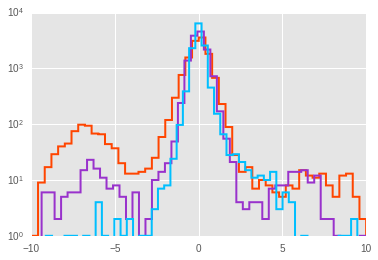

In [71]:
g = sns.distplot(aifo_rest1_gm_data[0], kde=False, hist=True, color='orangered',
                 hist_kws={'histtype': "step", 'alpha': 1, 'linewidth': 2})
g = sns.distplot(aifo_rest2_gm_data[0], kde=False, hist=True, color='darkorchid',
                 hist_kws={'histtype': "step", 'alpha': 1, 'linewidth': 2})
g = sns.distplot(aifo_rest3_gm_data[0], kde=False, hist=True, color='deepskyblue',
                 hist_kws={'histtype': "step", 'alpha': 1, 'linewidth': 2})
g.set_yscale('log')

### Plot Lag Distributions (per subject)

In [14]:
def dist_grid(data_1, data_2, data_3, subject_list):
    n_subs = len(subject_list)
    n_cols = 4
    n_rows = int(np.ceil(n_subs/(float(n_cols))))

    ax_idx_x= []
    ax_idx_y= []
    for idx_x in range(n_rows):
        for idx_y in range(n_cols):
            ax_idx_y.append(idx_y)
            ax_idx_x.append(idx_x)

    f, axarr = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, figsize=(12,2*n_rows))
    for idx, sub_id in enumerate(subject_list):
        sns.distplot(data_1[idx], hist=False, ax=axarr[ax_idx_x[idx], ax_idx_y[idx]], label='rest1')
        sns.distplot(data_2[idx], hist=False, ax=axarr[ax_idx_x[idx], ax_idx_y[idx]], label='rest2')
        sns.distplot(data_3[idx], hist=False, ax=axarr[ax_idx_x[idx], ax_idx_y[idx]], label='rest3')
        axarr[ax_idx_x[idx], ax_idx_y[idx]].legend()
        axarr[ax_idx_x[idx], ax_idx_y[idx]].set_title('Subject '+str(sub_id), fontsize=10)
    plt.xlim(-2, 2)
    plt.tight_layout()

#### AiFO

<IPython.core.display.Javascript object>


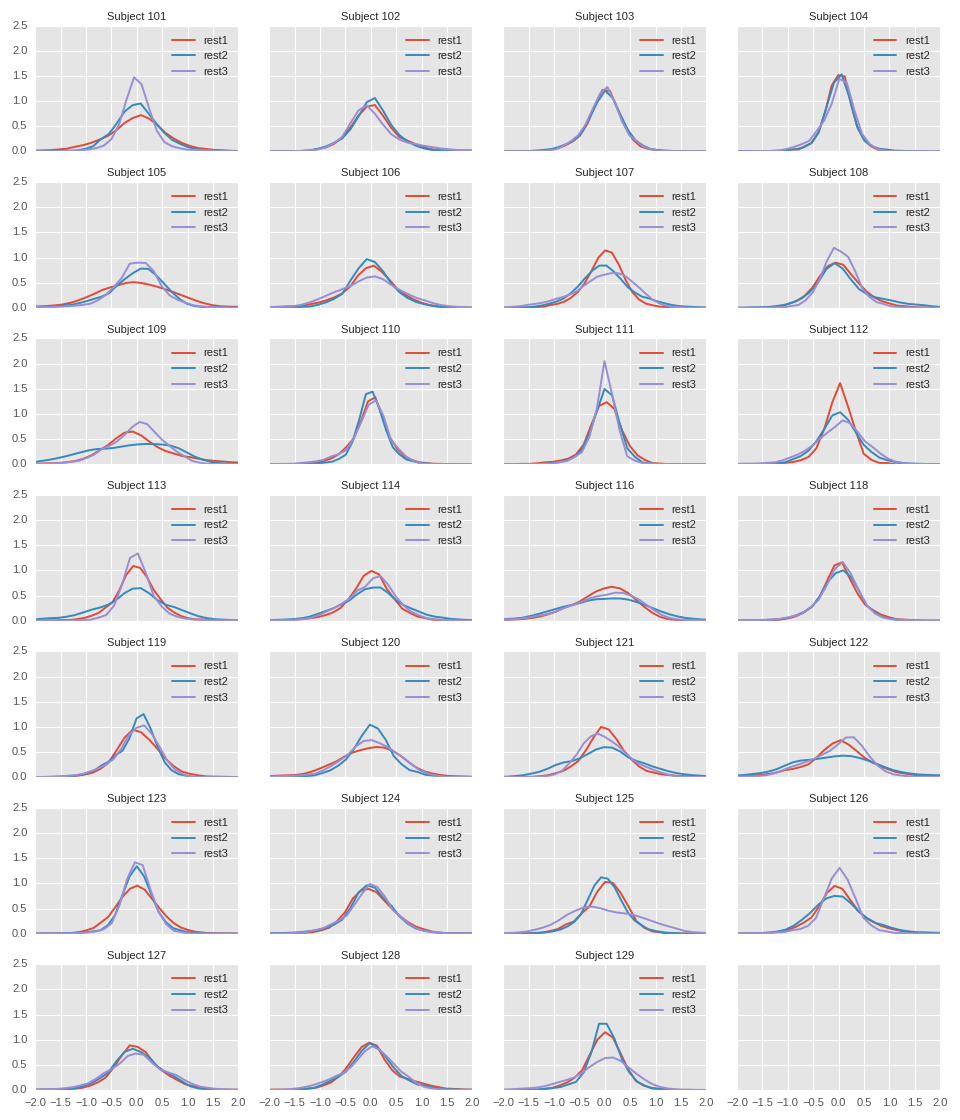

In [15]:
dist_grid(aifo_rest1_gm_data, aifo_rest2_gm_data, aifo_rest3_gm_data, subject_list)

#### dlPFC

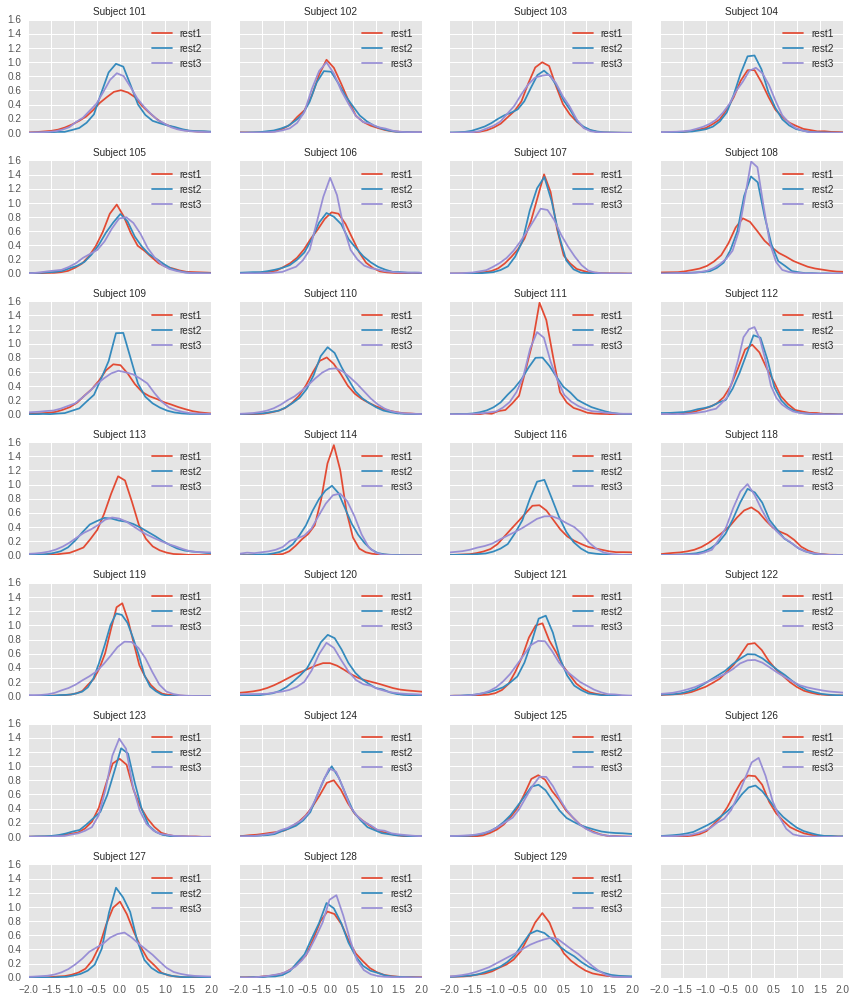

In [17]:
dist_grid(dlpfc_rest1_gm_data, dlpfc_rest2_gm_data, dlpfc_rest3_gm_data, subject_list)

#### S1

In [ ]:
dist_grid(sham_rest1_gm_data, sham_rest2_gm_data, sham_rest3_gm_data, subject_list)

### Plot changes in extreme leads/lags

In [ ]:
def count_extremes(sub_data, thresh):
    n_nonzero = np.count_nonzero(sub_data)
    n_greater = np.count_nonzero(sub_data <= -thresh)
    n_lesser = np.count_nonzero(sub_data >= thresh)
    pct_lead = np.true_divide(n_greater, n_nonzero)
    pct_lag = np.true_divide(n_lesser, n_nonzero)
    return pct_lead, pct_lag

In [ ]:
def compute_FD(file, units):
    """

    :rtype: object
    """
    import numpy as np

    if units == 'radians' or units == 'Radians':
        factor = 1
    elif units == 'degrees' or units == 'Degrees':
        factor = (np.pi / 180) * 50

    MP = np.loadtxt(file)
    AbsMotDiff = abs(np.diff(MP, axis=0))

    Trans = AbsMotDiff[:, 0:3]
    Rot = AbsMotDiff[:, 3:6]
    FD = np.sum(Trans, axis=1) + np.sum(factor * Rot, axis=1)

    return FD

In [ ]:
roi_list = ['aifo', 'dlpfc', 's1']
scan_list = ['rest1', 'rest2', 'rest3']
measures = ['pct_big_lead', 'pct_big_lag', 'pct_big_any', 'mean_fd', 'mean_lag']

row_store = []
for subject in subject_list:
    for roi in roi_list:
        for scan in scan_list:
            for measure in measures:
                row = [str(subject), roi, scan, measure]
                row_store.append(row)

dists_df_mindex = pd.MultiIndex.from_arrays(np.array(row_store).T, names=['sub_id', 'roi', 'scan', 'measure'])
dists_dframe = pd.DataFrame(index=dists_df_mindex)
dists_dframe['value'] = np.nan

In [ ]:
np.mean(aifo_rest1_gm_data[0])

In [ ]:
input_arrays =[[aifo_rest1_gm_data, 'aifo', 'rest1', 'Aifo', 'rest_1'],
               [aifo_rest2_gm_data, 'aifo', 'rest2', 'Aifo', 'rest_2'],
               [aifo_rest3_gm_data, 'aifo', 'rest3', 'Aifo', 'rest_3'],
               [dlpfc_rest1_gm_data, 'dlpfc', 'rest1', 'Dlpfc', 'rest_1'],
               [dlpfc_rest2_gm_data, 'dlpfc', 'rest2', 'Dlpfc', 'rest_2'],
               [dlpfc_rest3_gm_data, 'dlpfc', 'rest3', 'Dlpfc', 'rest_3'],
               [sham_rest1_gm_data, 's1', 'rest1', 'Sham', 'rest_1'],
               [sham_rest2_gm_data, 's1', 'rest2', 'Sham', 'rest_2'],
               [sham_rest3_gm_data, 's1', 'rest3', 'Sham', 'rest_3']]

for sub_array in input_arrays:
    data_array = sub_array[0]
    roi = sub_array[1]
    scan = sub_array[2]
    condition = sub_array[3]
    scan_name = sub_array[4]
    for idx, sub_id in enumerate(subject_list):
        sub_id = str(sub_id)
        counts = count_extremes(data_array[idx], 1)
        dists_dframe.ix[sub_id, roi, scan, 'pct_big_lead'] = counts[0]
        dists_dframe.ix[sub_id, roi, scan, 'pct_big_lag'] = counts[1]
        dists_dframe.ix[sub_id, roi, scan, 'pct_big_any'] = counts[0] + counts[1]
        scan_fd_array = compute_FD('/home/despo/dlurie/Projects/megarest_lag/data/sub{0}/{1}/sub{0}_{1}_{2}_motion_params.txt'.format(sub_id, condition, scan_name), 'degrees')
        dists_dframe.ix[sub_id, roi, scan, 'mean_fd'] = np.mean(scan_fd_array)
        dists_dframe.ix[sub_id, roi, scan, 'mean_lag'] = np.mean(data_array[idx])

In [ ]:
dists_dflat = dists_dframe.reset_index()
dists_df_leads = dists_dflat[dists_dflat['measure'] == 'pct_big_lead']
dists_df_lags = dists_dflat[dists_dflat['measure'] == 'pct_big_lag']
dists_df_any = dists_dflat[dists_dflat['measure'] == 'pct_big_any']
dists_df_fd = dists_dflat[dists_dflat['measure'] == 'mean_fd']
dists_df_mean = dists_dflat[dists_dflat['measure'] == 'mean_lag']

In [ ]:
g = sns.FacetGrid(dists_df_mean, col="roi", size=3, aspect=1, legend_out=False)
g.map(sns.swarmplot, "scan", "value", palette="Set2");
g.add_legend()
g.set_ylabels('Mean lag')

In [ ]:
stats.f_oneway(dists_df_mean[(dists_df_mean['scan']=='rest1') & (dists_df_mean['roi']=='aifo')]['value'],
               dists_df_mean[(dists_df_mean['scan']=='rest2') & (dists_df_mean['roi']=='aifo')]['value'],
               dists_df_mean[(dists_df_mean['scan']=='rest3') & (dists_df_mean['roi']=='aifo')]['value'])

In [ ]:
g = sns.FacetGrid(dists_df_mean, col="sub_id", size=2.7, aspect=.5, col_wrap=9, legend_out=False)
g.map(sns.pointplot, "scan", "value", 'roi', palette="Set2");
g.add_legend()
g.set_ylabels('Mean lag')

#### Percent of voxels with lead > 2s

In [ ]:
g = sns.FacetGrid(dists_df_leads, col="roi", size=3, aspect=1, legend_out=False)
g.map(sns.swarmplot, "scan", "value", palette="Set2");
g.add_legend()
g.set_ylabels('% vox w/ lead > 2s')

In [ ]:
stats.f_oneway(dists_df_leads[(dists_df_leads['scan']=='rest1') & (dists_df_leads['roi']=='aifo')]['value'],
               dists_df_leads[(dists_df_leads['scan']=='rest2') & (dists_df_leads['roi']=='aifo')]['value'],
               dists_df_leads[(dists_df_leads['scan']=='rest3') & (dists_df_leads['roi']=='aifo')]['value'])

In [ ]:
g = sns.FacetGrid(dists_df_leads, col="sub_id", size=3, aspect=1, col_wrap=4, legend_out=False)
g.map(sns.pointplot, "scan", "value", 'roi', palette="Set2");
g.add_legend()

#### Percent of voxels with lags > 2s

In [ ]:
g = sns.FacetGrid(dists_df_lags, col="roi", size=3, aspect=1, legend_out=False)
g.map(sns.swarmplot, "scan", "value", palette="Set2");
g.add_legend()

In [ ]:
stats.f_oneway(dists_df_lags[(dists_df_lags['scan']=='rest1') & (dists_df_lags['roi']=='aifo')]['value'],
               dists_df_lags[(dists_df_lags['scan']=='rest2') & (dists_df_lags['roi']=='aifo')]['value'],
               dists_df_lags[(dists_df_lags['scan']=='rest3') & (dists_df_lags['roi']=='aifo')]['value'])

In [ ]:
g = sns.FacetGrid(dists_df_lags, col="sub_id", size=3, aspect=1, col_wrap=4, legend_out=False)
g.map(sns.pointplot, "scan", "value", 'roi', palette="Set2");
g.add_legend()

#### Percent of voxels with leads or lags > 2s

In [ ]:
g = sns.FacetGrid(dists_df_any, col="roi", size=3, aspect=1, legend_out=False)
g.map(sns.swarmplot, "scan", "value", palette="Set2");
g.add_legend()
g.set_ylabels('% vox w/ lead or lag > 2s')

In [ ]:
stats.f_oneway(dists_df_any[(dists_df_any['scan']=='rest1') & (dists_df_any['roi']=='aifo')]['value'],
               dists_df_any[(dists_df_any['scan']=='rest2') & (dists_df_any['roi']=='aifo')]['value'],
               dists_df_any[(dists_df_any['scan']=='rest3') & (dists_df_any['roi']=='aifo')]['value'])

In [ ]:
g = sns.FacetGrid(dists_df_any, col="sub_id", size=2.7, aspect=.5, col_wrap=9, legend_out=False)
g.map(sns.pointplot, "scan", "value", 'roi', palette="Set2");
g.add_legend()
g.set_ylabels('% vox w/ lead or lag > 2s')

In [ ]:
print(str(stats.pearsonr(dists_df_fd['value'], dists_df_any['value'])))
sns.regplot(dists_df_fd['value'], dists_df_any['value'])
plt.xlabel('Mean FD')
plt.ylabel('% voxels > +/- 2s')

In [ ]:
sns.regplot(dists_df_fd['value'], dists_df_mean['value'], fit_reg=True)
plt.xlabel('Mean FD')
plt.ylabel('Mean Lag')

### TMS ROI Analysis

In [26]:
def resample_rois(condition_4d, condition_roi_paths):
    out_4d = []
    for idx, sub_img in enumerate(condition_4d):
        roi_path = condition_roi_paths[idx]
        roi_img = image.smooth_img(roi_path, None)
        roi_img_resampled = image.resample_to_img(roi_img, sub_img, interpolation='nearest')
        out_4d.append(roi_img_resampled)
    return out_4d

In [27]:
aifo_roi_paths = sorted(glob.glob('/home/despo/dlurie/Projects/megarest_lag/data/sub*/Aifo/sub*_Aifo_roi.nii.gz'))
dlpfc_roi_paths = sorted(glob.glob('/home/despo/dlurie/Projects/megarest_lag/data/sub*/Dlpfc/sub*_Dlpfc_roi.nii.gz'))
sham_roi_paths = sorted(glob.glob('/home/despo/dlurie/Projects/megarest_lag/data/sub*/Sham/sub*_S1_L_roi.nii.gz'))

In [28]:
aifo_resampled_rois = resample_rois(aifo_rest1_minimal_4d, aifo_roi_paths)
dlpfc_resampled_rois = resample_rois(dlpfc_rest1_minimal_4d, dlpfc_roi_paths)
sham_resampled_rois = resample_rois(sham_rest1_minimal_4d, sham_roi_paths)

In [29]:
cbf_under_coil_pre = np.loadtxt('/home/despo/cgratton/data/MegaRest.TMS/Data/ASLdata/global_norm/Alldata_undercoil_CBFmean_spss_pre.txt', dtype='S')
cbf_under_coil_post1 = np.loadtxt('/home/despo/cgratton/data/MegaRest.TMS/Data/ASLdata/global_norm/Alldata_undercoil_CBFmean_spss_post1.txt', dtype='S')
cbf_under_coil_post2 = np.loadtxt('/home/despo/cgratton/data/MegaRest.TMS/Data/ASLdata/global_norm/Alldata_undercoil_CBFmean_spss_post2.txt', dtype='S')

In [30]:
cbf_pre_df = pd.DataFrame(cbf_under_coil_pre[1:], columns=[s.lower() for s in cbf_under_coil_pre[0]])
cbf_post1_df = pd.DataFrame(cbf_under_coil_post1[1:], columns=[s.lower() for s in cbf_under_coil_post1[0]])
cbf_post2_df = pd.DataFrame(cbf_under_coil_post2[1:], columns=[s.lower() for s in cbf_under_coil_post2[0]])

In [31]:
cbf_pre_df = cbf_pre_df.set_index('sub')
cbf_post1_df = cbf_post1_df.set_index('sub')
cbf_post2_df = cbf_post2_df.set_index('sub')

In [32]:
roi_list = ['aifo', 'dlpfc', 's1']
scan_list = ['rest1', 'rest2', 'rest3']
measures = ['mean_lag', 'mean_cbf']

row_store = []
for subject in subject_list:
    for roi in roi_list:
        for scan in scan_list:
            for measure in measures:
                row = [str(subject), roi, scan, measure]
                row_store.append(row)

rois_df_mindex = pd.MultiIndex.from_arrays(np.array(row_store).T, names=['sub_id', 'roi', 'scan', 'measure'])
rois_dframe = pd.DataFrame(index=rois_df_mindex)
rois_dframe['value'] = np.nan

In [33]:
input_arrays =[[aifo_rest1_minimal_4d, aifo_resampled_rois, 'aifo', 'rest1'],
               [aifo_rest2_minimal_4d, aifo_resampled_rois, 'aifo', 'rest2'],
               [aifo_rest3_minimal_4d, aifo_resampled_rois, 'aifo', 'rest3'],
               [dlpfc_rest1_minimal_4d, dlpfc_resampled_rois, 'dlpfc', 'rest1'],
               [dlpfc_rest2_minimal_4d, dlpfc_resampled_rois, 'dlpfc', 'rest2'],
               [dlpfc_rest3_minimal_4d, dlpfc_resampled_rois, 'dlpfc', 'rest3'],
               [sham_rest1_minimal_4d, sham_resampled_rois, 's1', 'rest1'],
               [sham_rest2_minimal_4d, sham_resampled_rois, 's1', 'rest2'],
               [sham_rest3_minimal_4d, sham_resampled_rois, 's1', 'rest3']]

for sub_array in input_arrays:
    img_array = sub_array[0]
    roi_array = sub_array[1]
    roi = sub_array[2]
    scan = sub_array[3]
    for idx, sub_id in enumerate(subject_list):
        sub_id = str(sub_id)
        masked_data = masking.apply_mask(img_array[idx], roi_array[idx])
        rois_dframe.ix[sub_id, roi, scan, 'mean_lag'] = np.mean(masked_data)

KeyboardInterrupt: 

In [ ]:
input_arrays = [[cbf_pre_df, 'rest1'],
                [cbf_post1_df, 'rest2'],
                [cbf_post2_df, 'rest3']]

for sub_array in input_arrays:
    cbf_df = sub_array[0]
    scan = sub_array[1]
    for sub_id in subject_list:
        sub_id = str(sub_id)
        for roi in [('aifo', 'aifo'), ('dlpfc', 'dlpfc'), ('sham', 's1')]:
            col = '{0}tms_{1}cbf'.format(roi[0], roi[1])
            val = cbf_df.loc[sub_id, col]
            rois_dframe.ix[sub_id, roi[1], scan, 'mean_cbf'] = float(val)

In [ ]:
rois_dflat = rois_dframe.reset_index()
rois_dflat_cbf_all = rois_dflat[rois_dflat['measure'] == 'mean_cbf']
rois_dflat_lag_all = rois_dflat[rois_dflat['measure'] == 'mean_lag']
rois_dflat_cbf_pre = rois_dflat[(rois_dflat['measure'] == 'mean_cbf') & (rois_dflat['scan'] == 'rest1')]
rois_dflat_lag_pre = rois_dflat[(rois_dflat['measure'] == 'mean_lag') & (rois_dflat['scan'] == 'rest1')]
rois_dflat_cbf_post = rois_dflat[(rois_dflat['measure'] == 'mean_cbf') & (rois_dflat['scan'] == 'rest2')]
rois_dflat_lag_post = rois_dflat[(rois_dflat['measure'] == 'mean_lag') & (rois_dflat['scan'] == 'rest2')]
rois_dflat_cbf_dlpfc = rois_dflat[(rois_dflat['measure'] == 'mean_cbf') & (rois_dflat['roi'] == 'dlpfc')]
rois_dflat_lag_dlpfc = rois_dflat[(rois_dflat['measure'] == 'mean_lag') & (rois_dflat['roi'] == 'dlpfc')]

In [ ]:
cbf_diff = np.subtract(rois_dflat_cbf_post['value'], rois_dflat_cbf_pre['value'])

In [ ]:
lag_diff = np.subtract(rois_dflat_lag_post['value'], rois_dflat_lag_pre['value'])

In [ ]:
cbf_lower = (cbf_diff <=0).values

In [ ]:
cbf_lower

In [ ]:
foo = cbf_diff[cbf_lower].values

In [ ]:
bar = lag_diff[cbf_lower].values

In [ ]:
print(str(stats.pearsonr(foo, bar)))
sns.regplot(foo, bar)
plt.xlabel('Change in CBF at ROI')
plt.ylabel('Change in Lag at ROI')

In [ ]:
print(str(stats.pearsonr(np.absolute(cbf_diff), np.absolute(lag_diff))))
sns.regplot(np.absolute(cbf_diff), np.absolute(lag_diff))
plt.xlabel('Change in CBF at ROI')
plt.ylabel('Change in Lag at ROI')

In [ ]:
sns.regplot(dists_df_fd['value'], dists_df_any['value'])
plt.xlabel('Mean FD')
plt.ylabel('% voxels > +/- 2s')

In [ ]:
g = sns.FacetGrid(rois_dflat_lag, col="roi", size=3, aspect=1, legend_out=False)
g.map(sns.swarmplot, "scan", "value", palette="Set2");
g.add_legend()
g.set_ylabels('Mean lag within ROI')

In [ ]:
g = sns.FacetGrid(rois_dflat_cbf_all, col="roi", size=3, aspect=1, legend_out=False)
g.map(sns.swarmplot, "scan", "value", palette="Set2");
g.add_legend()
g.set_ylabels('Mean CBF within ROI')

In [ ]:
print(str(stats.pearsonr(rois_dflat_cbf_all['value'], rois_dflat_lag_all['value'])))
sns.regplot(rois_dflat_cbf_all['value'], rois_dflat_lag_all['value'])
plt.xlabel('Mean CBF at ROI')
plt.ylabel('Mean Lag at ROI')

In [ ]:
print(str(stats.pearsonr(rois_dflat_cbf_pre['value'], rois_dflat_lag_pre['value'])))
sns.regplot(rois_dflat_cbf_pre['value'], rois_dflat_lag_pre['value'])
plt.xlabel('Mean CBF at ROI')
plt.ylabel('Mean Lag at ROI')

In [ ]:
print(str(stats.pearsonr(rois_dflat_cbf_dlpfc['value'], rois_dflat_lag_dlpfc['value'])))
sns.regplot(rois_dflat_cbf_dlpfc['value'], rois_dflat_lag_dlpfc['value'])
plt.xlabel('Mean CBF at ROI')
plt.ylabel('Mean Lag at ROI')

In [ ]:
g = sns.FacetGrid(rois_dflat_cbf, col="sub_id", size=2.7, aspect=.5, col_wrap=9, legend_out=False)
g.map(sns.pointplot, "scan", "value", 'roi', linewidth=5, palette="Set2",);
g.add_legend()
g.set_ylabels('Mean lag within ROI')

In [ ]:
sns.set_context(rc={"lines.linewidth": 0.75})

In [ ]:
g = sns.FacetGrid(rois_dflat, col="sub_id", size=2.7, aspect=.5, col_wrap=9, legend_out=False)
g.map(sns.pointplot, "scan", "mean_lag_at_roi", 'roi', linewidth=5, palette="Set2",);
g.add_legend()
g.set_ylabels('Mean lag within ROI')

### Load and resample CBF images.

In [ ]:
aifo_rest1_mean_cbf_paths = ['/home/despo/cgratton/data/MegaRest.TMS/Data/{}_Aifo/Analysis/ASL_new/Block01/mask_files/norm_scCBF_timeseries_mask.nii.gz'.format(str(sub_id)) for sub_id in subject_list]
aifo_rest2_mean_cbf_paths = ['/home/despo/cgratton/data/MegaRest.TMS/Data/{}_Aifo/Analysis/ASL_new/Block02/mask_files/norm_scCBF_timeseries_mask.nii.gz'.format(str(sub_id)) for sub_id in subject_list]
aifo_rest3_mean_cbf_paths = ['/home/despo/cgratton/data/MegaRest.TMS/Data/{}_Aifo/Analysis/ASL_new/Block03/mask_files/norm_scCBF_timeseries_mask.nii.gz'.format(str(sub_id)) for sub_id in subject_list]

dlpfc_rest1_mean_cbf_paths = ['/home/despo/cgratton/data/MegaRest.TMS/Data/{}_Dlpfc/Analysis/ASL_new/Block01/mask_files/norm_scCBF_timeseries_mask.nii.gz'.format(str(sub_id)) for sub_id in subject_list]
dlpfc_rest2_mean_cbf_paths = ['/home/despo/cgratton/data/MegaRest.TMS/Data/{}_Dlpfc/Analysis/ASL_new/Block02/mask_files/norm_scCBF_timeseries_mask.nii.gz'.format(str(sub_id)) for sub_id in subject_list]
dlpfc_rest3_mean_cbf_paths = ['/home/despo/cgratton/data/MegaRest.TMS/Data/{}_Dlpfc/Analysis/ASL_new/Block03/mask_files/norm_scCBF_timeseries_mask.nii.gz'.format(str(sub_id)) for sub_id in subject_list]

sham_rest1_mean_cbf_paths = ['/home/despo/cgratton/data/MegaRest.TMS/Data/{}_Sham/Analysis/ASL_new/Block01/mask_files/norm_scCBF_timeseries_mask.nii.gz'.format(str(sub_id)) for sub_id in subject_list]
sham_rest2_mean_cbf_paths = ['/home/despo/cgratton/data/MegaRest.TMS/Data/{}_Sham/Analysis/ASL_new/Block02/mask_files/norm_scCBF_timeseries_mask.nii.gz'.format(str(sub_id)) for sub_id in subject_list]
sham_rest3_mean_cbf_paths = ['/home/despo/cgratton/data/MegaRest.TMS/Data/{}_Sham/Analysis/ASL_new/Block03/mask_files/norm_scCBF_timeseries_mask.nii.gz'.format(str(sub_id)) for sub_id in subject_list]

### Check for motion confound

In [ ]:
sub101_fd = compute_FD('/home/despo/dlurie/Projects/megarest_lag/data/sub102/Aifo/sub102_Aifo_rest_1_motion_params.txt', 'degrees')

In [ ]:
np.mean(sub101_fd)

In [ ]:
mp_test['Dmotion'][0][0].shape

In [ ]:
mp_test.keys()

In [ ]:
np.io.('/home/despo/arielle/megarest_sc/data/motion_params/101/motion_info_Aifo_FD_thr0.2.mat')

In [ ]:
plotting.plot_stat_map('/home/despo/dlurie/Projects/megarest_lag/analysis/sub110/Aifo/sub110_Aifo_minimal_r2minusr1_diffmap_smoothed5.nii.gz'
                       , bg_img=None, display_mode='z', black_bg=True)